In [6]:
# ipython --pylab

# import some needed functions
# import numpy as np
from scipy.integrate import odeint
from numpy import *
from matplotlib.pyplot import *

# set up a dictionary of parameters

E_params = {
        'E_leak' : -7.0e-2,
        'G_leak' : 3.0e-09,
        'C_m'    : 3.0e-11,
        'I_ext'  : 0*1.0e-10
}

Na_params = {
        'Na_E'          : 5.0e-2,
        'Na_G'          : 1.0e-6,
        'k_Na_act'      : 3.0e+0,
        'A_alpha_m_act' : 2.0e+5,
        'B_alpha_m_act' : -4.0e-2,
        'C_alpha_m_act' : 1.0e-3,
        'A_beta_m_act'  : 6.0e+4,
        'B_beta_m_act'  : -4.9e-2,
        'C_beta_m_act'  : 2.0e-2,
        'l_Na_inact'    : 1.0e+0,
        'A_alpha_m_inact' : 8.0e+4,
        'B_alpha_m_inact' : -4.0e-2,
        'C_alpha_m_inact' : 1.0e-3,
        'A_beta_m_inact'  : 4.0e+2,
        'B_beta_m_inact'  : -3.6e-2,
        'C_beta_m_inact'  : 2.0e-3
}

K_params = {
        'k_E'           : -9.0e-2,
        'k_G'           : 2.0e-7,
        'k_K'           : 4.0e+0,
        'A_alpha_m_act' : 2.0e+4,
        'B_alpha_m_act' : -3.1e-2,
        'C_alpha_m_act' : 8.0e-4,
        'A_beta_m_act'  : 5.0e+3,
        'B_beta_m_act'  : -2.8e-2,
        'C_beta_m_act'  : 4.0e-4
}

params = {
        'E_params'  : E_params,
        'Na_params' : Na_params,
        'K_params'  : K_params
}


In [4]:
# define our ODE function

def neuron(state, t, params):
        """
         Purpose: simulate Hodgkin and Huxley model for the action potential using
         the equations from Ekeberg et al, Biol Cyb, 1991.
         Input: state ([E m h n] (ie [membrane potential; activation of
                  Na++ channel; inactivation of Na++ channel; activation of K+
                  channel]),
                t (time),
                and the params (parameters of neuron; see Ekeberg et al).
         Output: statep (state derivatives).
        """

        E = state[0]
        m = state[1]
        h = state[2]
        n = state[3]

        Epar = params['E_params']
        Na   = params['Na_params']
        K    = params['K_params']

        # external current (from "voltage clamp", other compartments, other neurons, etc)
        I_ext = Epar['I_ext']

        # calculate Na rate functions and I_Na
        alpha_act = Na['A_alpha_m_act'] * (E-Na['B_alpha_m_act']) / (1.0 - exp((Na['B_alpha_m_act']-E) / Na['C_alpha_m_act']))
        beta_act = Na['A_beta_m_act'] * (Na['B_beta_m_act']-E) / (1.0 - exp((E-Na['B_beta_m_act']) / Na['C_beta_m_act']) )
        dmdt = ( alpha_act * (1.0 - m) ) - ( beta_act * m )

        alpha_inact = Na['A_alpha_m_inact'] * (Na['B_alpha_m_inact']-E) / (1.0 - exp((E-Na['B_alpha_m_inact']) / Na['C_alpha_m_inact']))
        beta_inact  = Na['A_beta_m_inact'] / (1.0 + (exp((Na['B_beta_m_inact']-E) / Na['C_beta_m_inact'])))
        dhdt = ( alpha_inact*(1.0 - h) ) - ( beta_inact*h )

        # Na-current:
        I_Na =(Na['Na_E']-E) * Na['Na_G'] * (m**Na['k_Na_act']) * h

        # calculate K rate functions and I_K
        alpha_kal = K['A_alpha_m_act'] * (E-K['B_alpha_m_act']) / (1.0 - exp((K['B_alpha_m_act']-E) / K['C_alpha_m_act']))
        beta_kal = K['A_beta_m_act'] * (K['B_beta_m_act']-E) / (1.0 - exp((E-K['B_beta_m_act']) / K['C_beta_m_act']))
        dndt = ( alpha_kal*(1.0 - n) ) - ( beta_kal*n )
        I_K = (K['k_E']-E) * K['k_G'] * n**K['k_K']

        # leak current
        I_leak = (Epar['E_leak']-E) * Epar['G_leak']

        # calculate derivative of E
        dEdt = (I_leak + I_K + I_Na + I_ext) / Epar['C_m']
        statep = [dEdt, dmdt, dhdt, dndt]

        return statep

In [7]:
# simulate

# set initial states and time vector
state0 = [-70e-03, 0, 1, 0]
t = arange(0, 0.2, 0.001)

# let's inject some external current
params['E_params']['I_ext'] = 1.0e-10

# run simulation
state = odeint(neuron, state0, t, args=(params,))

Text(0.5, 0, 'TIME (sec)')

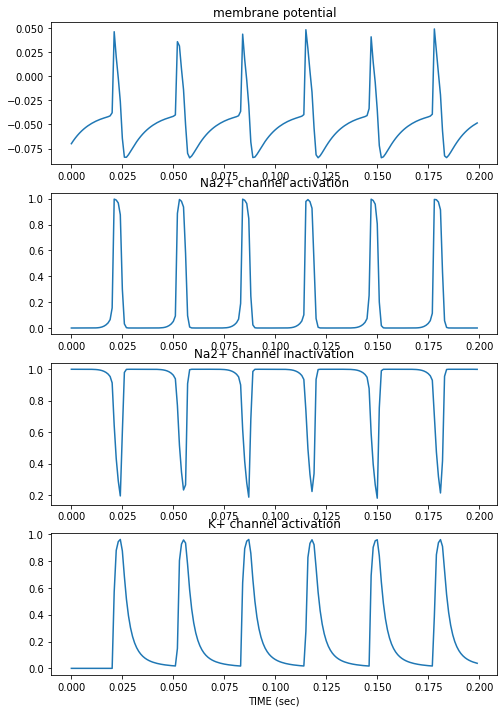

In [8]:
# plot the results

figure(figsize=(8,12))
subplot(4,1,1)
plot(t, state[:,0])
title('membrane potential')
subplot(4,1,2)
plot(t, state[:,1])
title('Na2+ channel activation')
subplot(4,1,3)
plot(t, state[:,2])
title('Na2+ channel inactivation')
subplot(4,1,4)
plot(t, state[:,3])
title('K+ channel activation')
xlabel('TIME (sec)')